# Refining the Frequency Extent of AKR Bursts
In this script we adjust the frequency limits from Fogg 2024 to a narrower range where the limits must fall upon the first filled channel as the limits increase and decrease in frequency for the lower and upper limits respectively

In [8]:
import pandas as pd
import numpy as np

In [ ]:
mask= pd.read_hdf('../../Example_Data/Waters_mask.hdf5', key='main')
flims= pd.read_csv('../../Example_Data/akr_flims.csv', parse_dates=['Date_UTC'])

/tmp/ipykernel_385138/3037946258.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  cbar= fig.colorbar(pc, cax=spect_cax, orientation='horizontal')


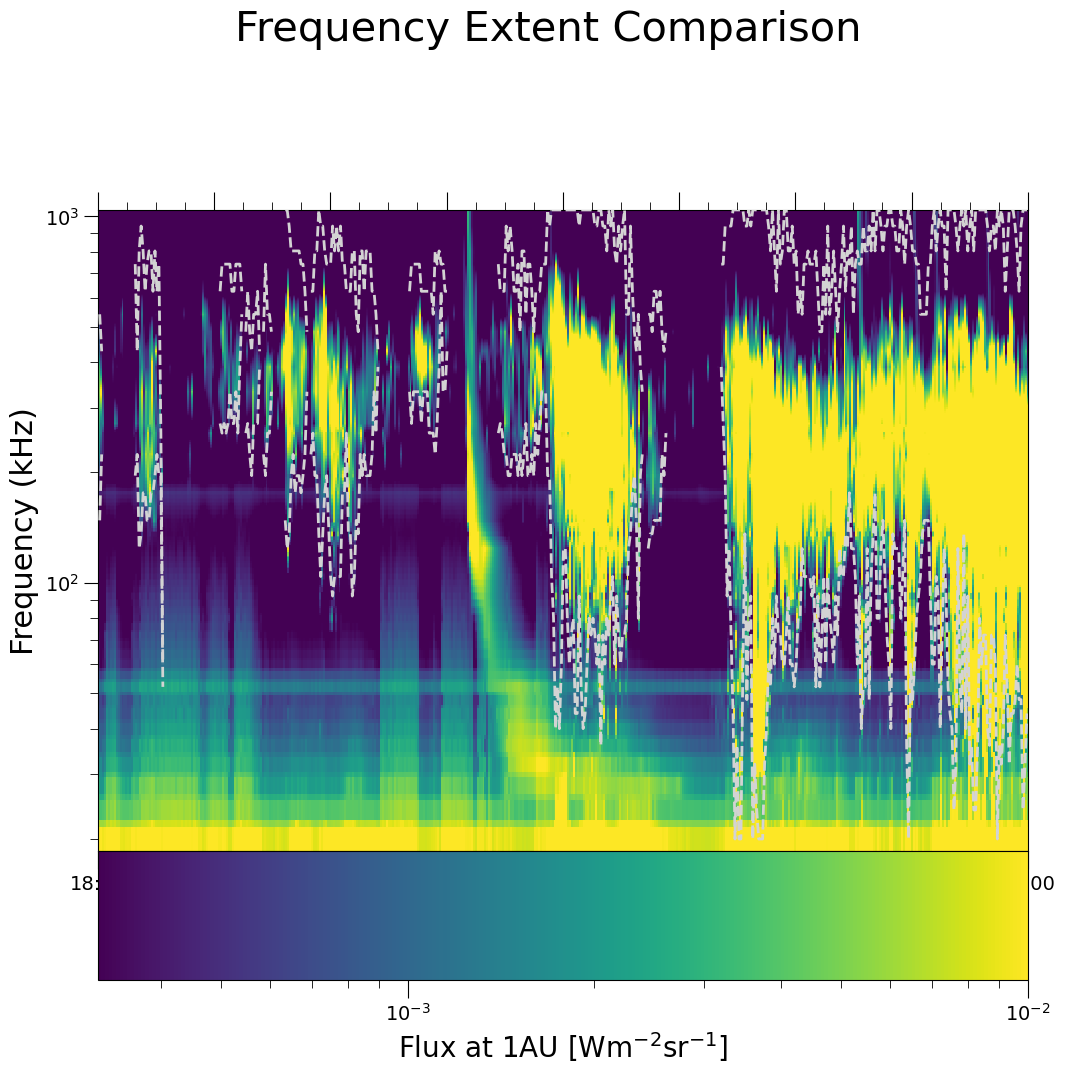

In [10]:
from Wind_Waves.plotting_tools import attach_corner_label, multi_xlabels, spectragram, mlt_formatter, combine_handles_labels, subplot_align
import numpy as np
start, end= np.datetime64('2004-02-05T18:00'), np.datetime64('2004-02-06T18:00') # set time range

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

fig= plt.figure(figsize=(12, 10))
fig.suptitle("Frequency Extent Comparison", 
                y=1.08, size=30)
gs= fig.add_gridspec(2, 1, height_ratios=[1, .2], width_ratios=[1], wspace=.1, hspace=0)
spect_ax= fig.add_subplot(gs[0])
spect_cax= fig.add_subplot(gs[1])
spect_ax.set_yscale('log')
spect_cax.set_yscale('log')
for ax in [spect_ax, spect_cax]:
    ax.minorticks_on()
    ax.tick_params(axis='y', which='major', size=10, labelsize=14)
    ax.tick_params(axis='x', which='major', size=13, labelsize=14)
    ax.tick_params(axis='both', which='minor', size=6, labelsize=14)
    time_fmt = mdates.DateFormatter('%H:%M')
for ax in [spect_ax]:
    ax.xaxis.set_major_formatter(time_fmt)
spect_ax.set_ylabel('Frequency (kHz)', size=22)
spect_ax.tick_params(axis='x', labelbottom=True, bottom=True, top=True, labeltop=False, which='both')
for ax in [spect_ax]:
    ax.set_xlim(start, end)

from Wind_Waves.integration_tools import create_sweeps, create_spins
from Wind_Waves.reading_tools import raw2csv
import vaex as vx
days = start+ np.arange((end.astype('datetime64[D]')-start.astype('datetime64[D]')).astype('timedelta64[D]')+1)
raw= vx.open(list((np.unique([raw2csv(date, '../../Example_Data/raw_rad1/', '../Example_Data/raw_rad1/') for date in (days)]))))
raw.drop('SWEEP', inplace=True)
raw= raw.to_pandas_df()
create_sweeps(raw, time='Date_UTC')
create_spins(raw, spin='SPIN')
raw= vx.from_pandas(raw)

pc, vals= spectragram(raw, ax=spect_ax, groupby='SWEEP', frequency='FREQ', datetime='DATETIME_Z', flux='VZPAL',
                    start=start, end=end, gap_filling='fill')
cbar= fig.colorbar(pc, cax=spect_cax, orientation='horizontal')
cbar.set_label('Flux at 1AU [Wm$^{-2}$sr$^{-1}$]', size=20)



plot_ind= (flims['Date_UTC']>=start)&(flims['Date_UTC']<=end)

spect_ax.plot(flims.loc[plot_ind, 'Date_UTC'], flims.loc[plot_ind, 'fmin'], color='lightgrey', lw=2, ls='--', label='Orginal Limits Burst', zorder=10)
spect_ax.plot(flims.loc[plot_ind, 'Date_UTC'], flims.loc[plot_ind, 'fmax'], color='lightgrey', lw=2, ls='--', zorder=10)


In [11]:
df= flims.merge(mask[['Date_UTC', 'akr_flux_si_1au', 'freq']], on='Date_UTC')

In [12]:
ind= (df['freq']<df['fmin'])|(df['freq']>df['fmax'])|(df.fmin.isna())|(df.fmax.isna())

df.loc[ind, ['akr_flux_si_1au']]=np.nan
df.loc[df['akr_flux_si_1au'].isna(), 'freq'] = np.nan
flims_refined= flims.copy()
flims_refined['fmin']=df.groupby('SWEEP').freq.min()
flims_refined['fmax']=df.groupby('SWEEP').freq.max()

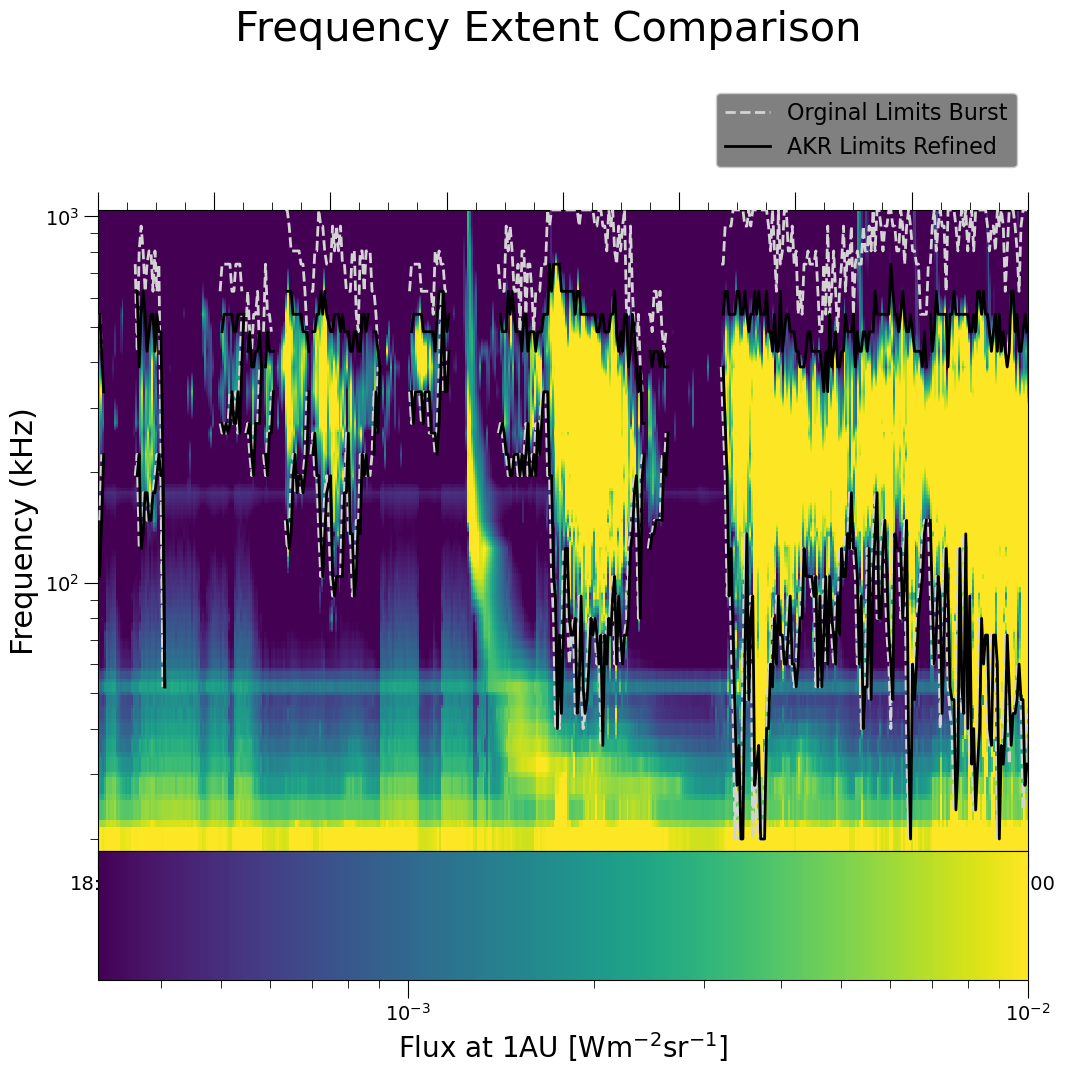

In [13]:
plot_ind= (flims_refined['Date_UTC']>=start)&(flims_refined['Date_UTC']<=end)

spect_ax.plot(flims_refined.loc[plot_ind, 'Date_UTC'], flims_refined.loc[plot_ind, 'fmin'], color='black', lw=2, ls='-', label='AKR Limits Refined', zorder=10)
spect_ax.plot(flims_refined.loc[plot_ind, 'Date_UTC'], flims_refined.loc[plot_ind, 'fmax'], color='black', lw=2, ls='-', zorder=10)
spect_ax.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1, 1.2), framealpha=1, facecolor='grey')

fig

In [ ]:
flims_refined.to_csv('../../Example_Data/akr_flims_refined.csv', index=False)